In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.image import imread

import plotly
import plotly.graph_objs as go

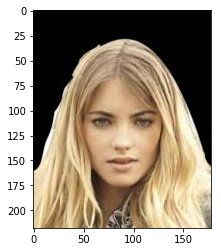

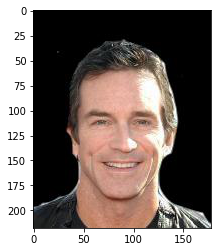

In [2]:
im1 = imread('1_w.jpg')
im2 = imread('2_w.jpg')

# im_five = (im_five>0).astype(int)
# im_three = (im_three>0).astype(int)
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()

In [3]:
def disp(im, P=None, cmap=None):
    plt.figure(None, figsize=(15,12))
    plt.imshow(im, cmap)
    if P is not None: plt.scatter(P[0,:], P[1,:])
    plt.show()

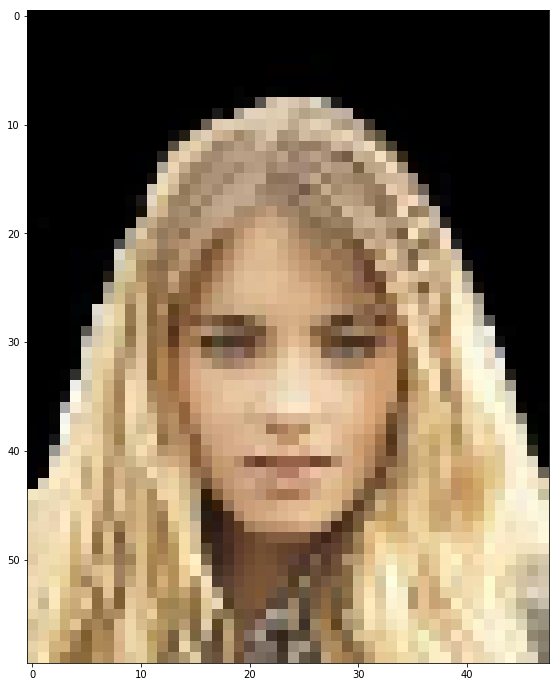

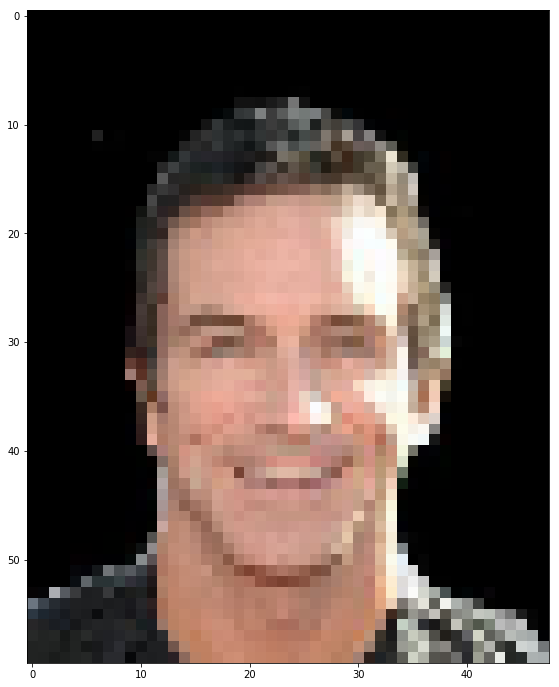

iteration: 500
iteration: 1000
iteration: 1500
iteration: 2000
iteration: 2500
iteration: 3000
iteration: 3500
iteration: 4000
iteration: 4500


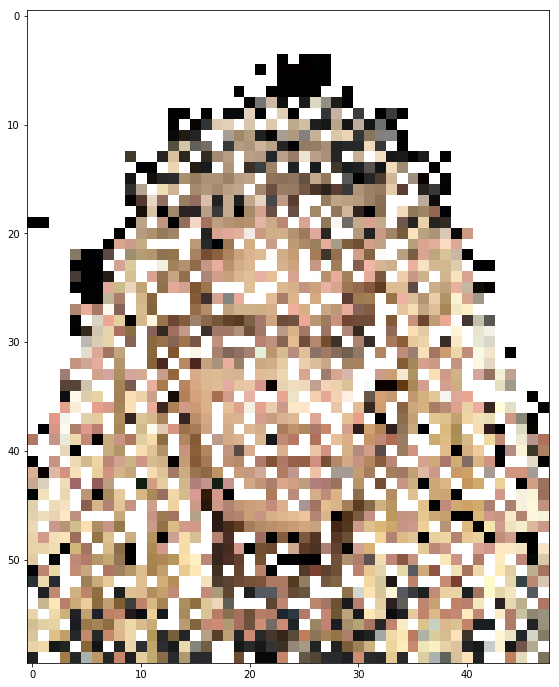

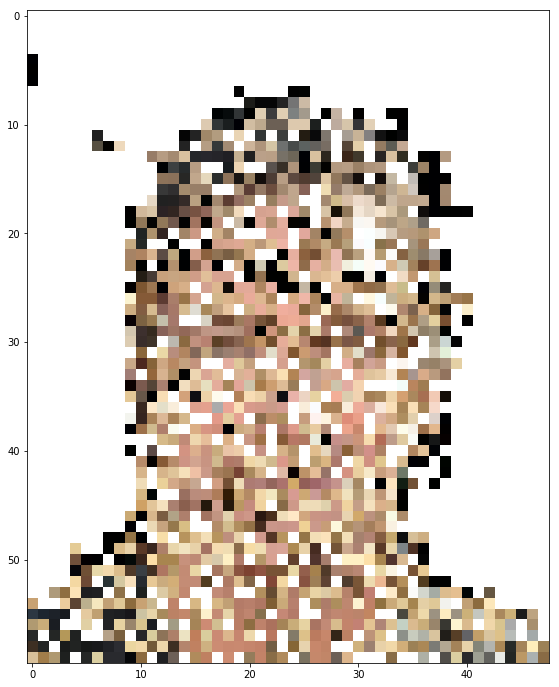

In [4]:
class MetamorphoseCreator:
    IMAGE_HEIGHT = 60 # The final height of the point cloud
    
    def pre_process_images(self, im1, im2):
        """
        Crop the two images to their connected components. 
        Then, rescale them so that their heights are the same, without changing the aspect ratio.
        
        """
#         im1 = self.get_connected_component_box(im1)
#         im2 = self.get_connected_component_box(im2)
        im1, im2 = self.resize_images(im1,im2)
        disp(im1)
        disp(im2)
        return im1, im2
        
    def __init__(self, im1, im2):
        """
        im1, im2 : Two binarized images (2d numpy array). 
        For best results, both should contain only a single connected component.
        """
        self.im1, self.im2 = self.pre_process_images(im1,im2)
        self.draw_space = np.zeros((self.im1.shape[0], self.im2.shape[1], self.im1.shape[1], 3))# * 255
    
    def get_connected_component_box(self, im):
        """
        im: binary image : mxn, containing a single connected component
        returns: image cropped to connected component
        """
    
        component_column_span = im.max(axis=0).nonzero()[0]
        y_min = component_column_span.min()
        y_max = component_column_span.max()

        component_row_span = im.max(axis=1).nonzero()[0]
        x_min = component_row_span.min()
        x_max = component_row_span.max()
        return im[x_min:x_max, y_min:y_max]
    
    def resize_images(self, im1, im2):
        """
        scale both images to IMAGE_HEIGHT
        """
        im1_width = int(im1.shape[1] * (self.IMAGE_HEIGHT/im1.shape[0]))
        im2_width = int(im2.shape[1] * (self.IMAGE_HEIGHT/im2.shape[0]))
        im1_resized = cv2.resize(im1.astype('float32') , dsize=(im1_width, self.IMAGE_HEIGHT, ))
        im2_resized = cv2.resize(im2.astype('float32') ,dsize=(im2_width, self.IMAGE_HEIGHT))
        return im1_resized.astype(int),im2_resized.astype(int)
        
    def get_projection(self, player):
        assert player < 3
        #TODO
        gray_draw_space = self.draw_space.mean(-1) # [50,40,40]
        x,y,z = gray_draw_space.nonzero()
        if player==1:
            projection = np.ones_like(self.im1, dtype='uint8') * 255
            xyz = sorted(zip(x,y,z),key=lambda x:x[2])#, reverse=True)
            for e in xyz:
                if np.all(projection[e[0],e[1]] == 255):
                    projection[e[0],e[1]] = self.draw_space[e[0],e[1],e[2],:]
        if player==2:
            projection = np.ones_like(self.im2, dtype='uint8') * 255
            xyz = sorted(zip(x,y,z),key=lambda x:x[1])#, reverse=True)
            for e in xyz:
                if np.all(projection[e[0],e[2]] == 255):
                    projection[e[0],e[2]] = self.draw_space[e[0],e[1],e[2],:]
        return projection
    
    def player_one_draw(self):
        """
        Player 1 draws a single point
        
        """
        projection = self.get_projection(1)
        remaining_image = self.im1-projection
        
        if remaining_image.sum() == 0:
            # Image completed
            return (-1, -1) #TODO ugly
        
        #Get a random remaining pixel
        remaining_unpainted_locs = remaining_image.nonzero()
        pixel_loc = np.random.randint(remaining_unpainted_locs[0].shape[0])
        return (remaining_unpainted_locs[0][pixel_loc], remaining_unpainted_locs[1][pixel_loc])
        
    def player_two_draw(self):
        """
        Player 2 draws a single point
        
        """
        projection = self.get_projection(2)
        remaining_image = self.im2-projection

        if remaining_image.sum() == 0:
            # Image completed
            return (-1, -1) #TODO ugly
        
        #Get a random remaining pixel
        remaining_unpainted_locs = remaining_image.sum(-1).nonzero()
        pixel_loc = np.random.randint(remaining_unpainted_locs[0].shape[0])
        return (remaining_unpainted_locs[0][pixel_loc], remaining_unpainted_locs[1][pixel_loc])
        
    def create_point_cloud(self):
        """
        Player 2 chooses an x,y (or rather, an (x,z))
        The point (x,z) is chosen as the first (from top-left) point 
        that has is already represented in the point cloud.
        
        Player 1 receives this x,z. The 'z' does not matter to player 1. No matter the value of z, the 
        projection to player 1 is the same.
        

        Player 1 tries to find a y for this point, by looking at the current pointcloud, 
        and player 1's target image. If no y can be found, player 2 assumes y=0 (TODO)
        
        This is then repeated with P1 choosing a x,y and passing to P2 to choose a z
        
        P1 and P2 alternate roles until both images have been completely created
        """
        intermediate_point_clouds = [] # for gif-creation
        x,z = (0,0)
        i=1
        N_iterations = 5000
        while (x!=-1) and i < N_iterations:
            
            intermediate_point_clouds.append(self.draw_space.copy())
            if i%500==0:
                print('iteration:', i)
            i+=1
            if i%2 == 0:
                
                x,z = self.player_two_draw()
                if x == -1:
                    break
                projection = self.get_projection(1)
                remaining_image = self.im1-projection
                row = remaining_image[x].sum(-1)
                if row.sum()<=0:
                    # overwrite a previous point if exists
                    original_row = self.im1[x]

                    if original_row.sum() == 0:
                        self.draw_space[x,z,0] = self.im2[x,z]
                    else:
                        possible_locs = original_row.nonzero()[0]
                        pixel_col = possible_locs[np.random.randint(len(possible_locs))]
                        self.draw_space[x,z,pixel_col] = self.im2[x,z]

                else:
                    col = np.random.randint(len(row))
                    self.draw_space[x,z,col] = self.im2[x,z]
            else:
                x,y = self.player_one_draw()
                if x == -1:
                    break
                projection = self.get_projection(2)
                remaining_image = self.im2-projection
                row = remaining_image[x].sum(-1)
                if row.sum()<=0:
                    # overwrite a previous point if exists
                    original_row = self.im2[x]

                    if original_row.sum() == 0:
                        self.draw_space[x,0,y] = self.im1[x,y]
                    else:
                        possible_locs = original_row.nonzero()[0]
                        pixel_col = possible_locs[np.random.randint(len(possible_locs))]
                        self.draw_space[x,pixel_col,y] = self.im1[x,y]

                else:
                    col = np.random.randint(len(row))
                    self.draw_space[x,col, y] = self.im1[x,y]
            if i >= N_iterations-1:
                disp(projection)
        return intermediate_point_clouds

d = MetamorphoseCreator(im1, im2)
intermediate_point_clouds = d.create_point_cloud()

In [7]:
z,x,y = d.draw_space.mean(-1).nonzero()

c = []
for z_i,x_i,y_i in zip(z,x,y):
    color = d.draw_space[z_i,x_i,y_i]
    c.append(color/255)

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()
    
# Configure the trace.
trace = go.Scatter3d(
    x=x,
    y=y,#[4, 5, 6],  # <-- Put your data instead
    z=-z, #[7, 8, 9],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 1.0,
        'color' : c
        
    },

)

# Configure the layout.
layout = go.Layout(
    showlegend = False,
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
    xaxis = {
#         'range': [0.2, 1],
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
    },
    yaxis = {
#         'range': [0.2, 1],
        'showgrid': False, # thin lines in the background
        'zeroline': False, # thick line at x=0
        'visible': False,  # numbers below
    }
)


data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

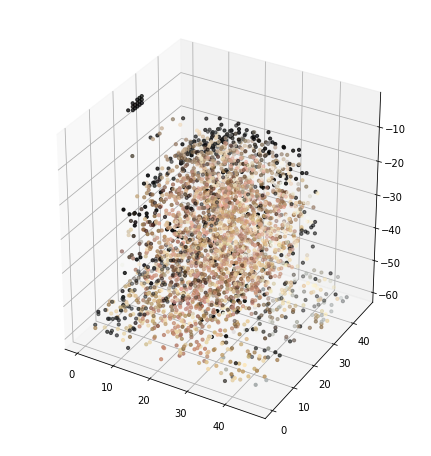

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(25,8))
ax = fig.add_subplot(131, projection='3d')

c = []
for z_i,x_i,y_i in zip(z,x,y):
    col = d.draw_space[z_i,x_i,y_i]
    c.append(col/255)
ax.scatter(x, y, -z, c=c, s=10)

plt.show()

In [ ]:
len(c)

In [ ]:
# temp = d.get_projection(2)
# plt.imshow(temp)
# plt.show()
# temp = d.get_projection(1)
# plt.imshow(temp)
# plt.show()

In [ ]:
d.draw_space.shape

In [ ]:
# def first_nonzero(arr, axis, invalid_val=-1):
#     mask = arr!=0
#     return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

# plt.show()
# print(d.draw_space.shape)
# colors = np.zeros(d.draw_space.shape)
# frontmost_z = first_nonzero(d.draw_space, 1)
# plt.imshow(frontmost_z)

# for i in range(frontmost_z.shape[0]):
#     for j in range(frontmost_z.shape[1]):
#         if frontmost_z[i][j]!=-1:
#             colors[i][frontmost_z[i][j]][j] = 1

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_3d(arr, fname):
    fig = plt.figure(figsize=(24,8))

    gray_draw_space = arr.mean(-1)
    z,x,y = gray_draw_space.nonzero()
    c = []
    for z_i,x_i,y_i in zip(z,x,y):
        col = d.draw_space[z_i,x_i,y_i]
        c.append(col/255)
    ax = fig.add_subplot(131, projection='3d')
    ax.scatter(x, y, -z, c=c, s=10)
    
    projection1 = np.ones([*arr.shape[:2],3], dtype='uint8') * 255
    x,y,z = gray_draw_space.nonzero()
    xyz = sorted(zip(x,y,z),key=lambda x:x[2])#, reverse=True)
    for e in xyz:
        if np.all(projection1[e[0],e[1]] == 255):
            projection1[e[0],e[1]] = arr[e[0],e[1],e[2],:]
    ax = fig.add_subplot(132)
    ax.imshow(projection1)

    projection2 = np.ones([*arr.shape[:2],3], dtype='uint8') * 255
    xyz = sorted(zip(x,y,z),key=lambda x:x[1])#, reverse=True)
    for e in xyz:
        if np.all(projection2[e[0],e[2]] == 255):
            projection2[e[0],e[2]] = arr[e[0],e[1],e[2],:]
    ax = fig.add_subplot(133)
    ax.imshow(projection2)

    fig.tight_layout()
    
    plt.savefig(fname)
    plt.close()

In [10]:
len(intermediate_point_clouds)

4999

In [11]:
import tqdm


In [15]:
!mkdir outputs1

In [16]:
## Create Images

for i, arr in tqdm.tqdm_notebook(enumerate(intermediate_point_clouds), total=len(intermediate_point_clouds)):
    if i%10 != 0: continue
    plot_3d(intermediate_point_clouds[i], 'outputs1/'+str(i)+'.png')

In [18]:
import os

In [20]:
c = 0
for i, arr in tqdm.tqdm_notebook(enumerate(intermediate_point_clouds), total=len(intermediate_point_clouds)):
    if i%10 != 0: continue
    os.rename('outputs1/'+str(i)+'.png', 'outputs1/'+str(c)+'.png')
    c+=1

In [21]:
print(len(intermediate_point_clouds))

4999


In [22]:
!ffmpeg -framerate 90 -i outputs1/%d.png -r 15 out.mp4 -y

ffmpeg version 4.0 Copyright (c) 2000-2018 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/maks/anaconda3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --enable-shared --enable-static --enable-zlib --enable-pic --enable-gpl --enable-version3 --disable-nonfree --enable-hardcoded-tables --enable-avresample --enable-libfreetype --disable-openssl --disable-gnutls --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --disable-libx264
  libavutil      56. 14.100 / 56. 14.100
  libavcodec     58. 18.100 / 58. 18.100
  libavformat    58. 12.100 / 58. 12.100
  libavdevice    58.  3.100 / 58.  3.100
  libavfilter     7. 16.100 /  7. 16.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  1.100 /  5.  1.100
  libswresample   3.  1.100 /  3.  1.100
  libpostproc    55.  1.100 / 55.  1.100
Input #0, image2, from 'outputs1/%d.png':
  Duration: 00:00:05.56, start: 0.000000, bitrate: N/A
    Stream #0:0

In [23]:
from IPython.display import HTML

In [24]:
HTML("""
<video width="600" height="500" controls>
  <source src="out.mp4" type="video/mp4">
</video>
""")